# import the packages


In [531]:
import tensorflow.keras.backend as K

K.clear_session()  # Clear any previous models/graphs


In [532]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.optimizers import Adam
#from utils import config
#from utils.conv_bc_model import BC_Model
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import cv2
import keras


# Defining a function for plotting the count of data against each class in each directory


In [533]:
def plotData(dirPath):
    # Get the path to the benign and malignant sub-directories
    cats_cases_dir = dirPath + '/cats/'
    dogs_cases_dir = dirPath + '/dogs/'

    # Get the list of all the images
    cats_cases_dir = glob.glob(cats_cases_dir + '*.jpg')
    dogs_cases_dir = glob.glob(dogs_cases_dir + '*.jpg')

    # An empty list. We will insert the data into this list in (img_path, label) format
    data1 = []

    # Go through all the benign cases. The label for these cases will be 0
    for img in cats_cases_dir:
        data1.append((img, 'cats'))

    # Go through all the malignant cases. The label for these cases will be 1
    for img in dogs_cases_dir:
        data1.append((img, 'dogs'))

    # Get a pandas dataframe from the data we have in our list
    data1 = pd.DataFrame(data1, columns=['image', 'label'], index=None)

    # Shuffle the data
    data1 = data1.sample(frac=1.).reset_index(drop=True)

    # Get the counts for each class
    cases_count = data1['label'].value_counts()
    print(cases_count)

    # Plot the results
    plt.figure(figsize=(10, 8))
    sns.barplot(x=cases_count.index, y=cases_count.values)
    plt.title('Number of cases', fontsize=14)
    plt.xlabel('Case type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(range(len(cases_count.index)), ['cats(cats)', 'dogs(dogs)'])
    plt.show()

label
cats    3000
dogs    3000
Name: count, dtype: int64


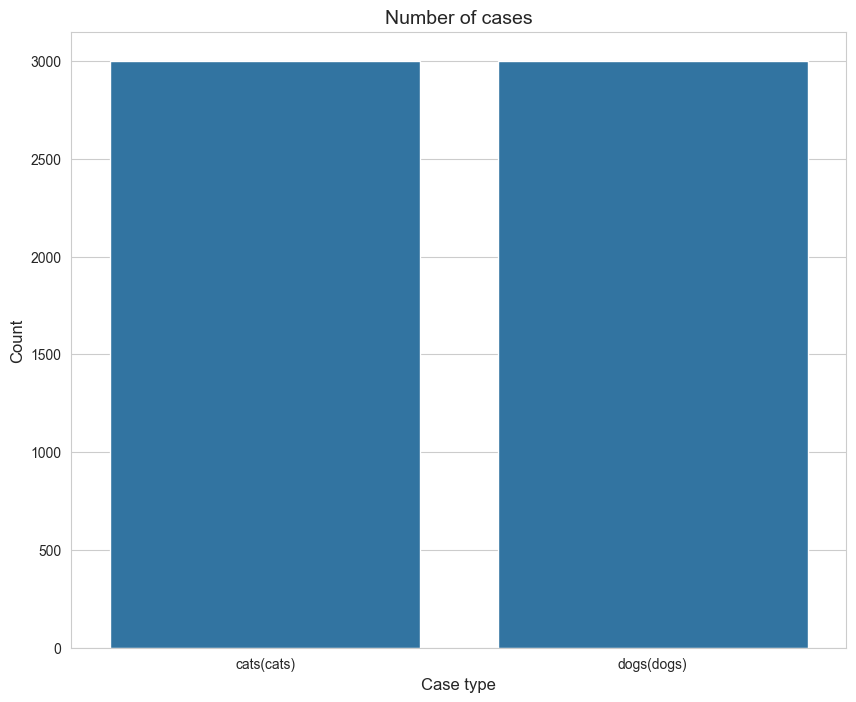

label
dogs    1000
cats    1000
Name: count, dtype: int64


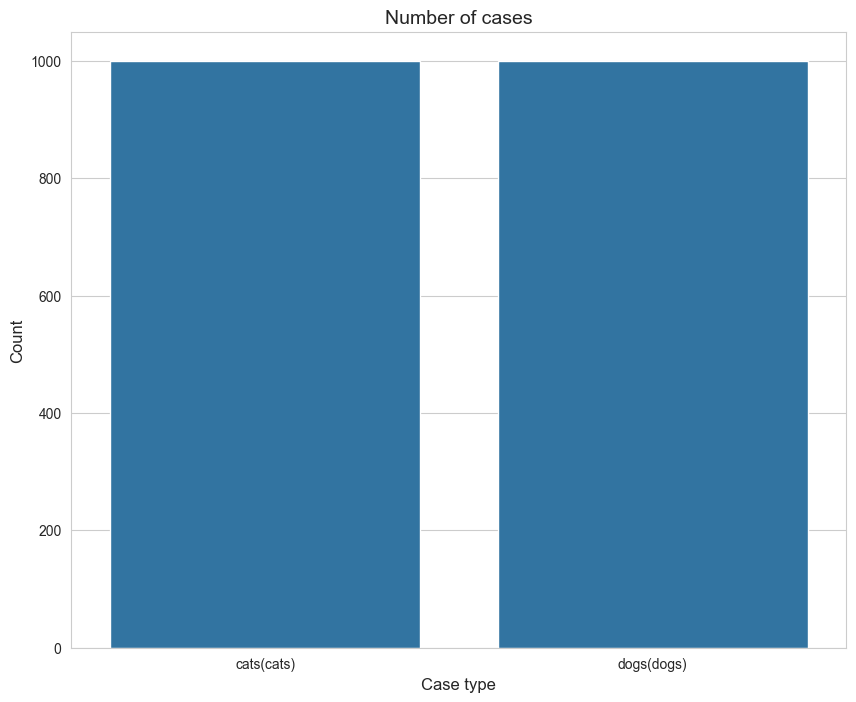

label
dogs    1000
cats    1000
Name: count, dtype: int64


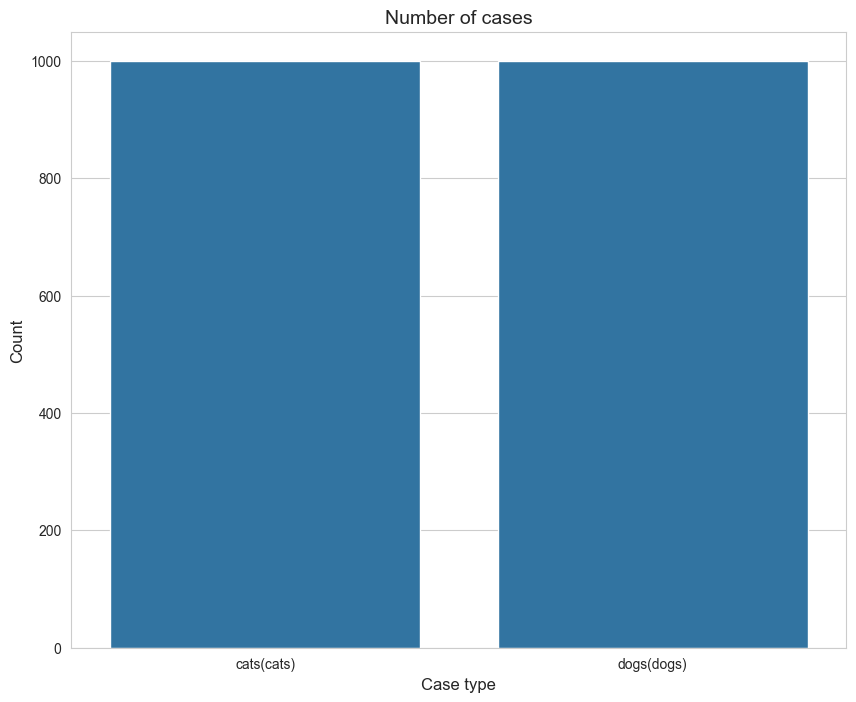

In [534]:
plotData('data/train')
plotData('data/test')
plotData('data/valid')

# Get few samples for both the classes


In [535]:
cats_cases_dir = 'data/train/cats/'
dogs_cases_dir = 'data/train/dogs/'

# Get the list of all the images
cats_cases_dir = glob.glob(cats_cases_dir + '*.jpg')
dogs_cases_dir = glob.glob(dogs_cases_dir + '*.jpg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data1 = []

# Go through all the benign cases. The label for these cases will be 0
for img in cats_cases_dir:
    train_data1.append((img,0))

# Go through all the malignant cases. The label for these cases will be 1
for img in dogs_cases_dir:
    train_data1.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data1 = pd.DataFrame(train_data1, columns=['image', 'label'],index=None)

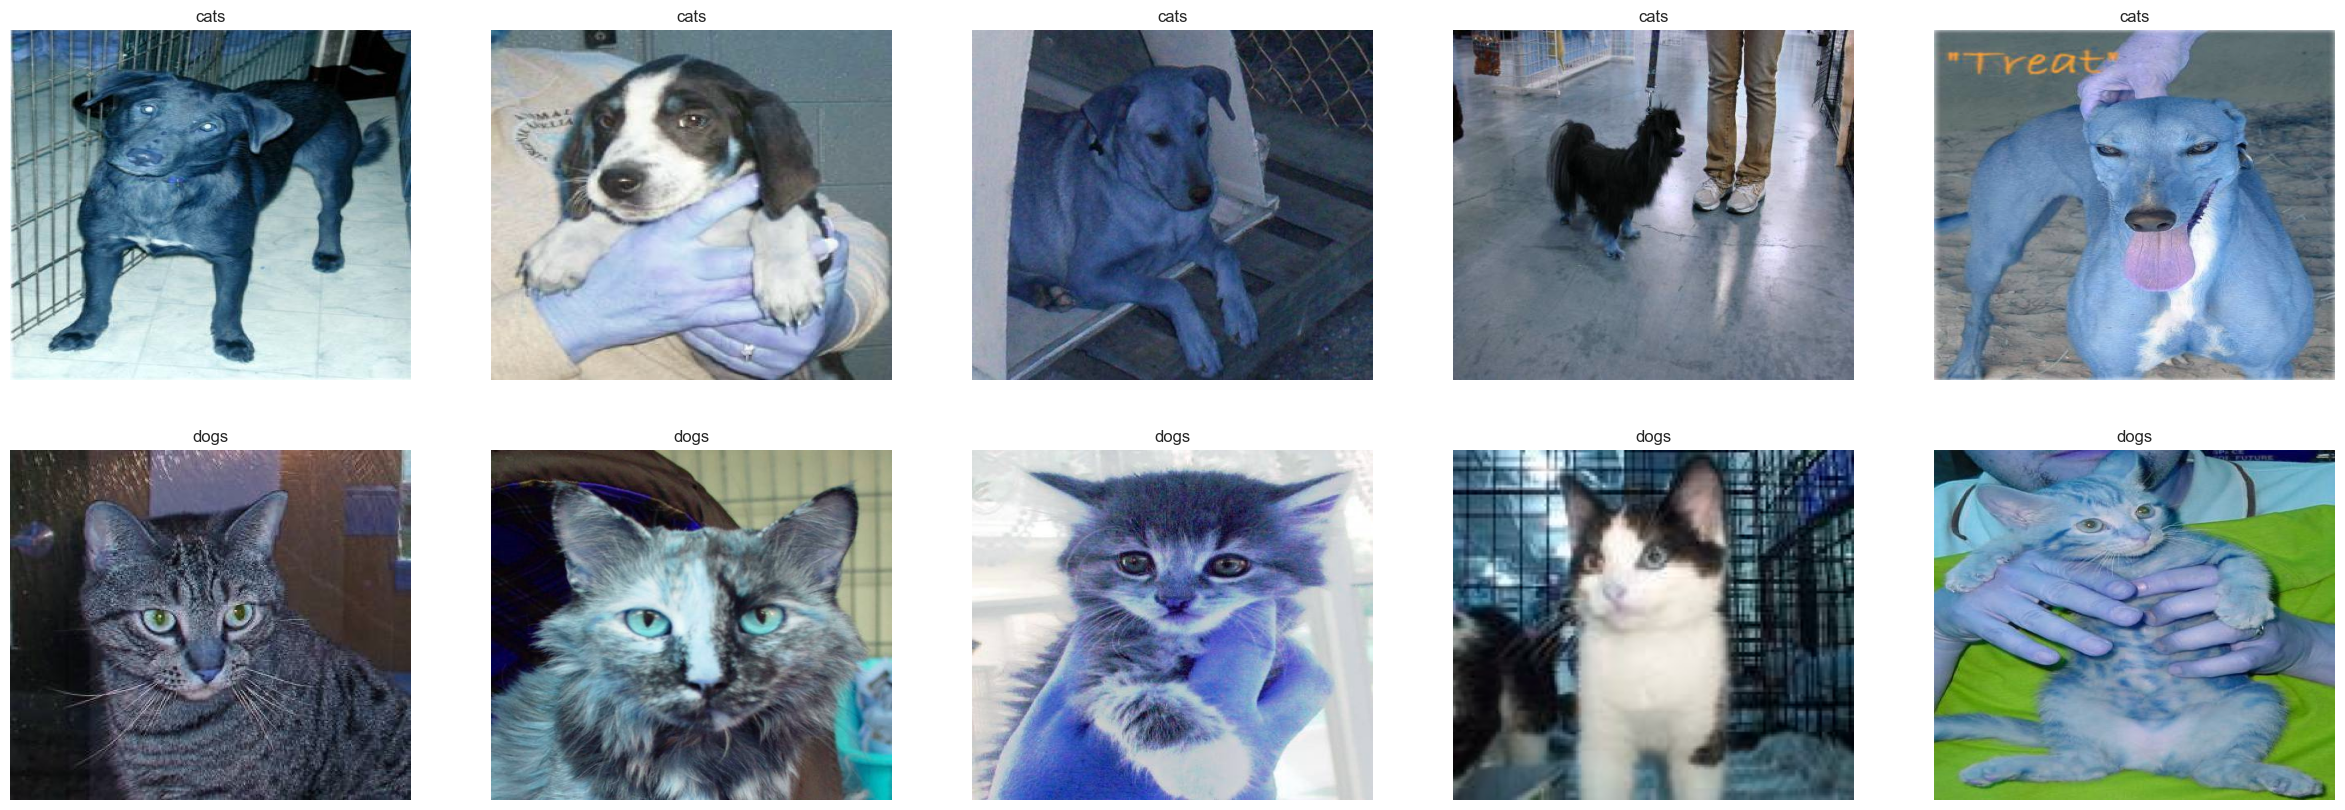

In [536]:
malignant_samples = (train_data1[train_data1['label']==1]['image'].iloc[:5]).tolist()
benign_samples = (train_data1[train_data1['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = malignant_samples + benign_samples
del malignant_samples, benign_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("cats")
    else:
        ax[i//5, i%5].set_title("dogs")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

# Defining a method to get the number of files given a path


In [537]:
def retrieveNumberOfFiles(path): 
    cats_cases_dir = os.path.join(path, 'cats')
    dogs_cases_dir = os.path.join(path, 'dogs')
    list0 = os.listdir(cats_cases_dir) 
    list1 = os.listdir(dogs_cases_dir)  
    return len(list0) , len(list1)

In [538]:
totalTrain = retrieveNumberOfFiles('data/train')[0] + retrieveNumberOfFiles('data/train')[1]
totalVal = retrieveNumberOfFiles('data/valid')[0] + retrieveNumberOfFiles('data/valid')[1]
totalTest = retrieveNumberOfFiles('data/test')[0] + retrieveNumberOfFiles('data/test')[1]
print(totalTrain)

6000


# Initialize the training and valid data augmentation object

In [539]:
trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

In [540]:
valAug = ImageDataGenerator(rescale=1/255.0)

In [541]:
# Initialize the training generator
trainGen = trainAug.flow_from_directory(
	'data/train',
	class_mode="categorical",
	target_size=(244, 244),
	color_mode="rgb",
	shuffle=True,
	batch_size=16)
for images, labels in trainGen: 
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}") 
    print(f"Images dtype: {images.dtype}, Labels dtype: {labels.dtype}")
    break
images, labels = next(trainGen)
print("Images shape:", images.shape)  # (16, 244, 244, 3)
print("Labels shape:", labels.shape)  # (16, num_classes)



Found 6000 images belonging to 2 classes.
Images shape: (16, 244, 244, 3), Labels shape: (16, 2)
Images dtype: float32, Labels dtype: float32
Images shape: (16, 244, 244, 3)
Labels shape: (16, 2)


In [542]:
# Initialize the validation generator

valGen = valAug.flow_from_directory(
	'data/valid',
	class_mode="categorical",
	target_size=(244, 244),
	color_mode="rgb",
	shuffle=False,
	batch_size=16)

Found 2000 images belonging to 2 classes.


# test generation

In [543]:
# Initialize the testing generator

testGen = valAug.flow_from_directory(
	'data/test',
	class_mode="categorical",
	target_size=(244, 244),
	color_mode="rgb",
	shuffle=False,
	batch_size=16)

Found 2000 images belonging to 2 classes.


# Building the CNN model

In [544]:
# Importing packages

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# be sure about last layer output number should match num of class!
class BC_Model:
    @staticmethod
    def build(width, height, depth, classes):
    
        # Lets first initialize the model with input shape to be "channels last" and channel's dimension
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # If we are using "channels first", then let's update the input shape and channel's dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
            
        # (CONV2D => RELU => BN ) * 1 => POOL => DROPOUT
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV2D => RELU => BN ) * 2 => POOL => DROPOUT
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV2D => RELU => BN ) * 3 => POOL => DROPOUT
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV2D => RELU => BN ) * 4 => POOL => DROPOUT
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # FC => RELU layers => BN => DROPOUT
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # Dense layer and softmax 'sigmoid' classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        # Returning the created network architecture
        return model


In [545]:
#RGB images (3 channels): The depth would be 3 because there are three color channels (Red, Green, Blue).
#Grayscale images (1 channel): The depth would be 1 because there is only one channel representing the intensity of the image.

dogs_cats_cnn_model = BC_Model.build(width=244, height=244, depth=3, classes=2)

C:\Users\wajee\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [546]:
# input shap for debugging
print(dogs_cats_cnn_model.input_shape)
print(dogs_cats_cnn_model.output_shape)


(None, 244, 244, 3)
(None, 2)


# Compiling the model and setting learning rate

In [547]:
## Decay updates the learning rate by a decreasing factor in each epoch

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)
opt = Adam(learning_rate=lr_schedule)
#Since you are using softmax activation in the output layer, you should use categorical_crossentropy as the loss function.
dogs_cats_cnn_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Fitting the model on training data and getting class weights

In [548]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Example counts for the training set
train_counts = {'cats': retrieveNumberOfFiles('data/train')[0], 'dogs': retrieveNumberOfFiles('data/train')[1]}

# Labels for the training set
y_train = [0] * train_counts['cats'] + [1] * train_counts['dogs']  # 0 for cats, 1 for dogs

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Convert to dictionary format
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")


Class weights: {0: 1.0, 1: 1.0}


In [549]:
#dogs_cats_cnn_model.summary()

In [550]:
# Using ModelCheckpoint to store the best performing model based on val_loss
# Save the best model based on validation loss (or any other metric)
checkpoint = ModelCheckpoint('best_model.keras', 
                             save_best_only=True, 
                             monitor='val_loss', 
                             mode='min', 
                             verbose=1)

# Stop training early if validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,  # Number of epochs with no improvement before stopping
                               mode='min', 
                               verbose=1)

#callbacks = [checkpoint_callback, early_stopping_callback]

In [551]:
steps_per_epoch = trainGen.samples // trainGen.batch_size
validation_steps = valGen.samples // valGen.batch_size
#trainGen = trainGen.repeat()
# Start training
history = dogs_cats_cnn_model.fit(
    trainGen,
    steps_per_epoch=steps_per_epoch,
    epochs=100,  # specify the number of epochs you want
    validation_data=valGen,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping]  # include both callbacks
)

C:\Users\wajee\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5276 - loss: 1.1439
Epoch 1: val_loss improved from inf to 1.22155, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 927s 2s/step - accuracy: 0.5276 - loss: 1.1436 - val_accuracy: 0.4965 - val_loss: 1.2216
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/100


C:\Users\wajee\miniconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
C:\Users\wajee\miniconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
C:\Users\wajee\miniconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5540 - loss: 0.9588
Epoch 3: val_loss improved from 1.22155 to 1.21429, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 877s 2s/step - accuracy: 0.5540 - loss: 0.9587 - val_accuracy: 0.5755 - val_loss: 1.2143
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5656 - loss: 0.8938
Epoch 5: val_loss improved from 1.21429 to 0.74609, saving model to best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 961s 3s/step - accuracy: 0.5656 - loss: 0.8939 - val_accuracy: 0.5635 - val_loss: 0.7461
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5625 - loss: 0.9291
Epoch 7: val_loss did not improve from 0.74609
375/375 ━━━━━━━━━━━━━━━━━━━━ 1014s 3s/step - accuracy: 0.5625 - loss: 0.9291 - val_accuracy: 0.5675 - val_l

In [552]:
# This saves the model after all epochs, or after early stopping, if applicable
dogs_cats_cnn_model.save('final_model.keras')

# continue training the model for more epochs and new LR optimizer

# Define the learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=5000,
    decay_rate=0.8,
    staircase=True)

# Create a new optimizer with the learning rate schedule
opt = Adam(learning_rate=lr_schedule)

# Re-compile the model with the new optimizer
dogs_cats_cnn_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Set the callbacks again (for checkpoint, early stopping, etc.)
callbacks = [checkpoint, early_stopping]
# Load the best model saved during previous training
dogs_cats_cnn_model = keras.models.load_model('best_model.keras')

steps_per_epoch = trainGen.samples // trainGen.batch_size
validation_steps = valGen.samples // valGen.batch_size
# Continue training the model for more epochs
history = dogs_cats_cnn_model.fit(
    trainGen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,  # 10 -> 10 -> 20 -> 50 (total(pre+curr))
    validation_data=valGen,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping],  # Continue using the same callbacks
    initial_epoch=history.epoch[-1] if 'history' in locals() else 0
)# Continue from the last epoch

# This saves the model after all epochs, or after early stopping, if applicable
dogs_cats_cnn_model.save('final_model.keras')

# Monitor the Training Process

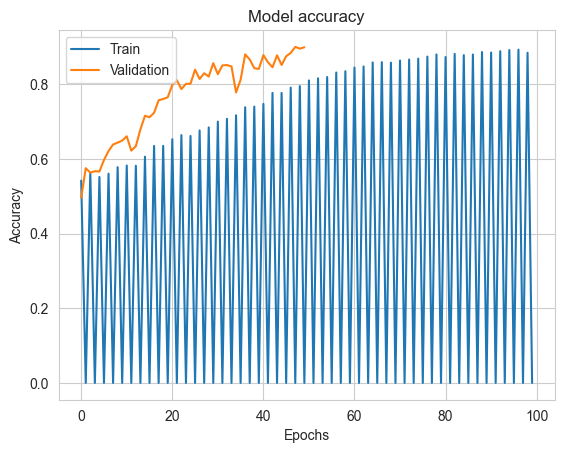

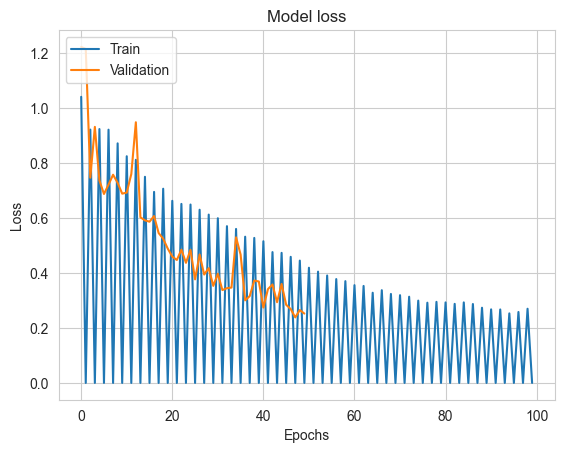

In [553]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Evaluate the Model

In [554]:
# Evaluate model performance on the test set
test_loss, test_accuracy = dogs_cats_cnn_model.evaluate(
    testGen, 
    steps=testGen.samples // testGen.batch_size)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 508ms/step - accuracy: 0.9202 - loss: 0.2131
Test loss: 0.23246526718139648
Test accuracy: 0.9079999923706055


# Predictions

In [558]:
# Load the best saved custom CNN model
from tensorflow.keras.utils import load_img, img_to_array
best_model = load_model("best_model.keras")
image_path = "dog.jpg"
img = load_img(image_path, target_size=(244, 244))  # Use your input size
img_array = img_to_array(img)  # Convert to numpy array
img_array = img_array / 255.0  # Normalize if required
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Get predictions (probabilities for each class)
predictions = best_model.predict(img_array)

# Extract probability of the predicted class
predicted_class = np.argmax(predictions, axis=1)  # Class index
predicted_probability = predictions[0][predicted_class[0]]  # Probability of that class
# Assuming you used ImageDataGenerator
print(testGen.class_indices)  # Dictionary mapping labels to indices
print(f"Predicted class: {predicted_class[0]}")
print(f"Predicted probability: {predicted_probability:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
{'cats': 0, 'dogs': 1}
Predicted class: 1
Predicted probability: 1.00
